In [1]:
import numpy as np
import numpy.random as rnd
import scipy.stats
import scipy.special
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Decoding Voltages
## Forward Probabilities
Consider a situation where you are communicating using electrical signals. Symbols are transmitted by setting a particular voltage $S$ on a wire. The problem for the decoder is that the wire accumulates electrical noise, so the voltage the receiver measures is:
$$V = S + \epsilon \qquad \text{with} \qquad
\epsilon \sim \mathcal{N}(0, \sigma^2) \,.$$
Using transformation of variables, we can show (good exercise) that $p(v|s) = \mathcal{N}(v; s, \sigma^2)$.

To gain a bit of insight, let's first start by plotting the _forward probability_ $p(v|s)$.

Text(0.5, 1.0, 'Density of observing $V$ given $S$, $\\sigma=0.63$')

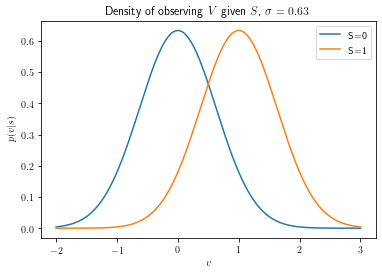

In [2]:
eps_std = 0.63
plotv = np.linspace(-2, 3, 500)
p_v_c_s = np.vstack([scipy.stats.norm.pdf(plotv, loc=l, scale=eps_std) for l in [0, 1]]).T
lines = plt.plot(plotv, p_v_c_s)
plt.legend(lines, ['S=0', 'S=1'])
plt.xlabel('$v$')
plt.ylabel('$p(v|s)$')
plt.title(f"Density of observing $V$ given $S$, $\sigma={eps_std}$")

So we can see that there is a region where the same data can be generated by both possible values of $S$. So there necessarily will be some uncertainty about what $S$ was if we observe only $V$.

This overlap depends on the level of noise. If we could reduce the noise variance $\sigma^2$, then this overlap would become less of a problem. If we had a reduced $\sigma=0.1$, then the densities would hardly overlap, and we could draw a near-faultless conslusion about what $S$ was, simply by checking whether $V > 0.5$ or so.

Text(0.5, 1.0, 'Density of observing $V$ given $S$, $\\sigma=0.1$')

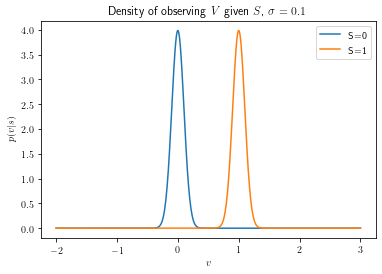

In [3]:
eps_std = 0.1
p_v_c_s2 = np.vstack([scipy.stats.norm.pdf(plotv, loc=l, scale=eps_std) for l in [0, 1]]).T
lines = plt.plot(plotv, p_v_c_s2)
plt.legend(lines, ['S=0', 'S=1'])
plt.xlabel('$v$')
plt.ylabel('$p(v|s)$')
plt.title(f"Density of observing $V$ given $S$, $\sigma={eps_std}$")

However, let's consider the unlucky situation where we had significant overlap. If we observe a particular voltage $V$, what should our belief over $S$ be?

## Reverse Probabilities
For the receiver, the transmitted voltage is unknown, so we represent our uncertainty by placing a distribution over it. We start with a binary case, where the transmitted voltage is considered to have been sampled from a Bernoulli distribution with $p=0.5$, i.e. with an equal tendancy to transmit both symbols:
$$S \sim \mathrm{Bernoulli}(0.5)\,.$$

We can now use Bayes' theorem to find our belief over the source voltage $S$:
\begin{align}
p(s|v) = \frac{p(v|s)p(s)}{p(v)}
\end{align}
and remember how to find $p(v)$ using the sum rule:
\begin{align}
p(v) = \int p(v|s) p(s) \mathrm d s \,.
\end{align}
Here we write an integral even though $S$ is a discrete random variable. We can consider the density $p(s)$ to be a sum of delta functions, i.e. $p(s) = 0.5\delta(s) + 0.5\delta(s-1)$, which means the integral reduces to a sum.

Either way, we notice that by the product rule we can also write Bayes rule in terms of the _joint_ density. We see that Bayes' rule tells us that the conditional is just the joint evaluated at some point, and then normalised:
\begin{align}
p(s|v) = \frac{p(v,s)}{\int p(v, s) \mathrm ds} \,.
\end{align}

We can visualise this for our problem. In the plot below the circles indicate the joint evaluated for an observed value $v$. Try changing `obs_v` to see the different relative probabilites.

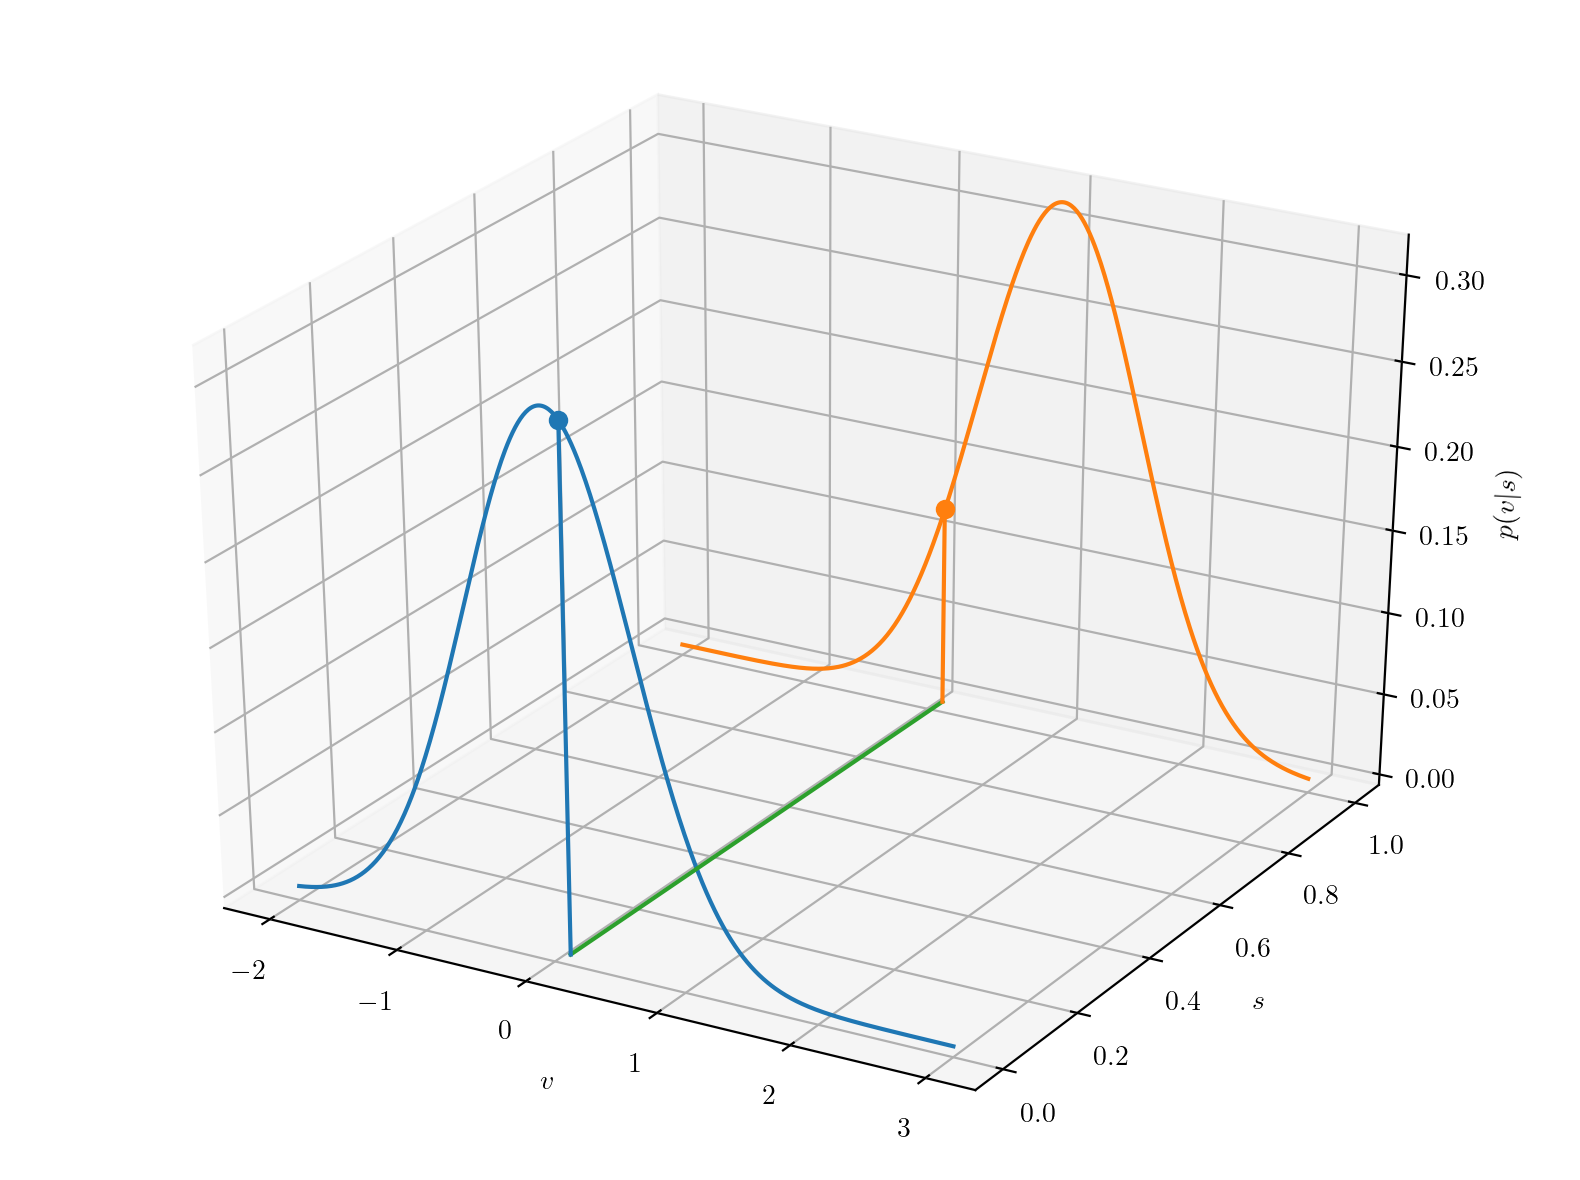

In [4]:
obs_v = 0.123

p_vs = p_v_c_s * 0.5

plt.figure(figsize=(8, 6), dpi=200)
ax = plt.axes(projection ='3d')
for i in range(p_vs.shape[1]):
    ax.plot3D(plotv, i + np.zeros(len(plotv)), p_vs[:, i])
ax.set_ylabel("$s$")
ax.set_xlabel("$v$")
ax.set_zlabel("$p(v|s)$")

index_v_obs = np.argmin((plotv - obs_v)**2.0)
s_at_v = p_vs[index_v_obs, :]

ax.plot3D(obs_v * np.ones(3), np.linspace(0, p_vs.shape[1] - 1, 3), 0.0 * np.ones(3))
for i in range(p_vs.shape[1]):
    ax.plot3D(obs_v * np.ones(3), i * np.ones(3), np.linspace(0, s_at_v[i], 3), color=f'C{i}')
    ax.plot3D([obs_v], [i], s_at_v[i], 'o', color=f'C{i}')
plt.tight_layout()

We can also visualise this as a bar plot:

Text(0.5, 1.0, 'Evaluated joint')

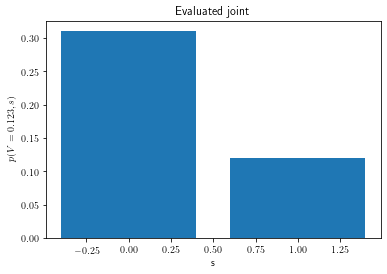

In [5]:
plt.bar([0, 1], s_at_v)
plt.ylabel(f"$p(V={obs_v}, s)$")
plt.xlabel("s")
plt.title("Evaluated joint")

This is not the posterior yet. It is not even a probability distribution, since if we sum over all the values of $s$, we get a value other than 1!

In [6]:
print(s_at_v.sum())

0.4310097005564615


However, if we normalise according to what Bayes rule tells us, we get a proper posterior probability distribution.

Text(0.5, 1.0, 'Posterior distribution')

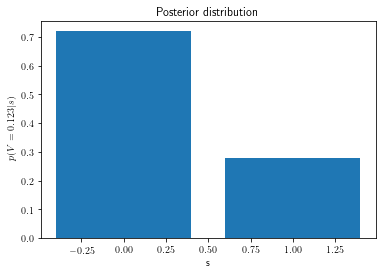

In [7]:
plt.bar([0, 1], s_at_v / s_at_v.sum())
plt.ylabel(f"$p(V={obs_v}|s)$")
plt.xlabel("s")
plt.title("Posterior distribution")

## Multiple voltages
We can repeat this same process when we want to transmit many different voltages. The only thing that changes, is the prior distribution on $S$. Here we take a prior over many values, and we also stop using a uniform prior, which could be the case if certain voltages are more common than others:
$$
P(S = s) = [0.4, 0.3, 0.1, 0.2]_s
$$
We can similarly plot the joint distribution, and the posterior.

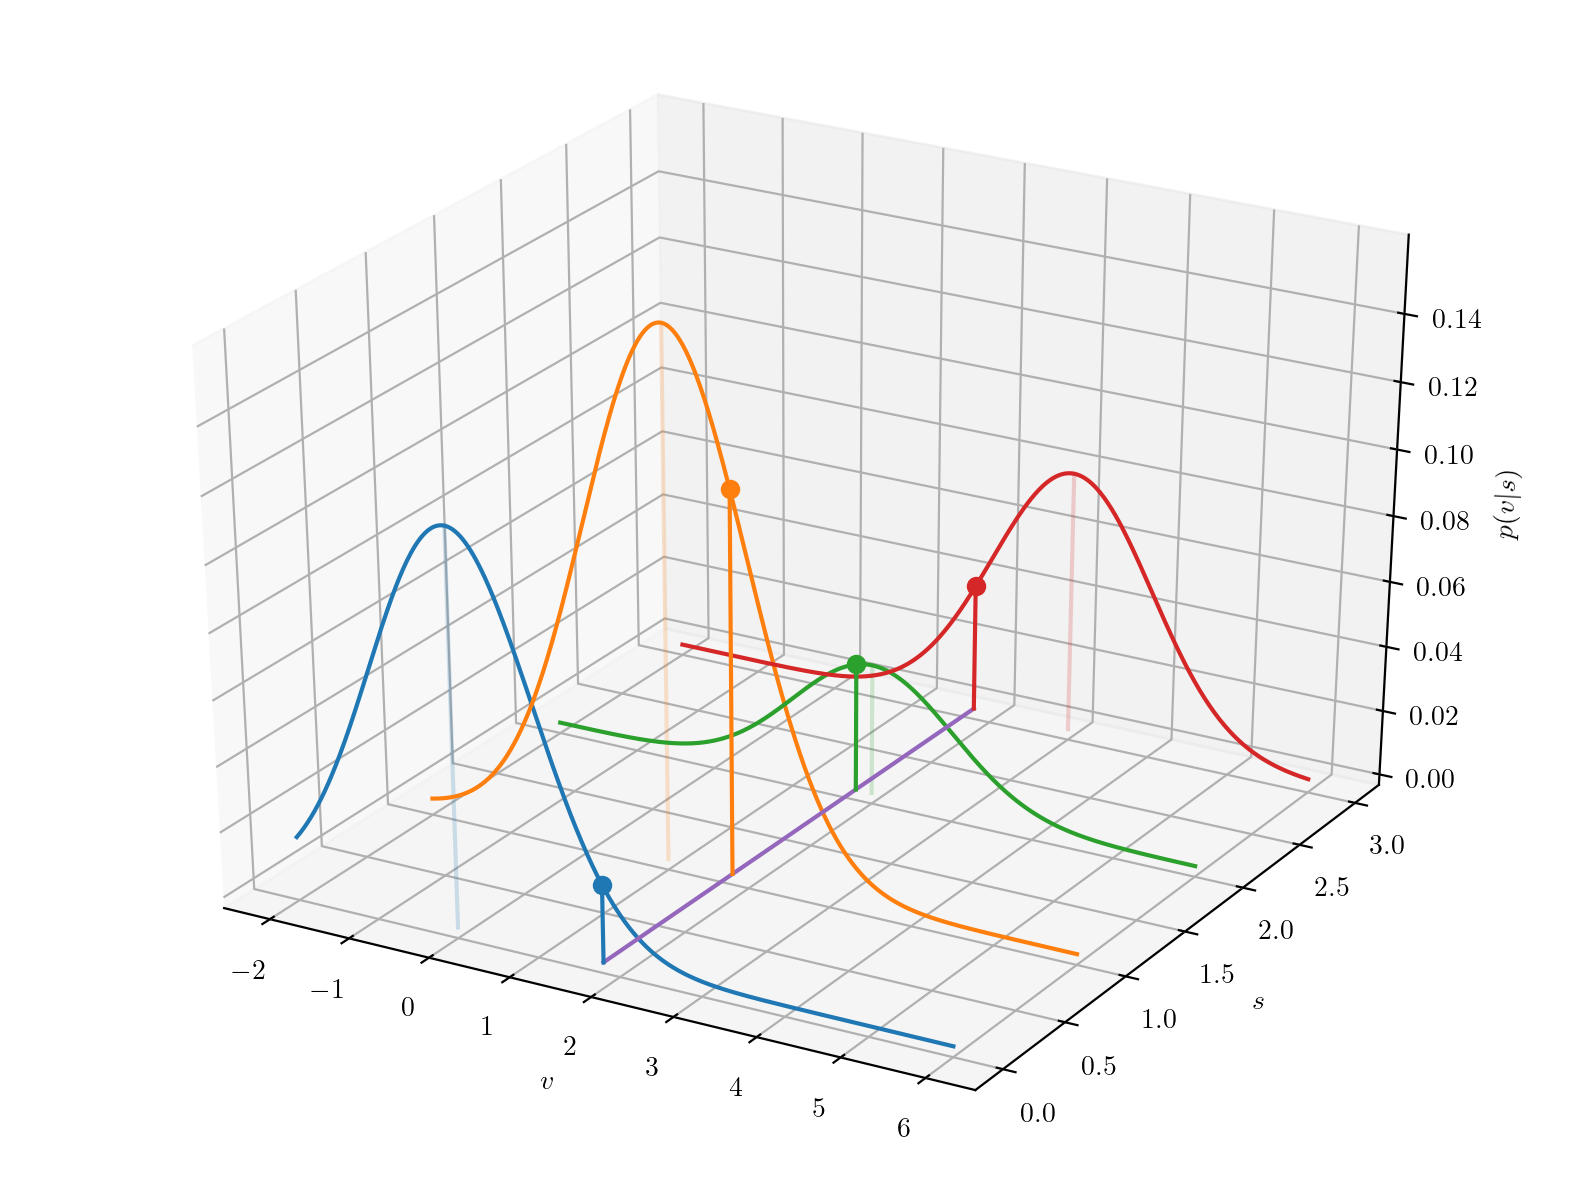

In [8]:
eps_std = 1.0
plotv = np.linspace(-2, 6, 500)
p_v_c_s = np.vstack([scipy.stats.norm.pdf(plotv, loc=l, scale=eps_std) for l in range(4)]).T

obs_v = 1.8

p_vs = p_v_c_s * np.array([0.3, 0.4, 0.1, 0.2])[None, :]

plt.figure(figsize=(8, 6), dpi=200)
ax = plt.axes(projection ='3d')
for i in range(p_vs.shape[1]):
    ax.plot3D(i * np.ones(3), i * np.ones(3), np.linspace(0, p_vs[:, i].max(), 3),
              color=f'C{i}', alpha=0.2)
    ax.plot3D(plotv, i + np.zeros(len(plotv)), p_vs[:, i])
ax.set_ylabel("$s$")
ax.set_xlabel("$v$")
ax.set_zlabel("$p(v|s)$")

index_v_obs = np.argmin((plotv - obs_v)**2.0)
s_at_v = p_vs[index_v_obs, :]

ax.plot3D(obs_v * np.ones(3), np.linspace(0, p_vs.shape[1] - 1, 3), 0.0 * np.ones(3))
for i in range(p_vs.shape[1]):
    ax.plot3D(obs_v * np.ones(3), i * np.ones(3), np.linspace(0, s_at_v[i], 3), color=f'C{i}')
    ax.plot3D([obs_v], [i], s_at_v[i], 'o', color=f'C{i}')
plt.tight_layout()

Text(0.5, 1.0, 'Posterior distribution')

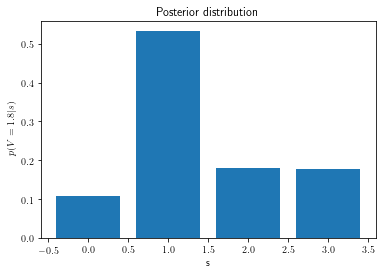

In [9]:
plt.bar(np.arange(len(s_at_v)), s_at_v / s_at_v.sum())
plt.ylabel(f"$p(V={obs_v}|s)$")
plt.xlabel("s")
plt.title("Posterior distribution")

Here we look at a uniform case again, but with _many_ different voltage levels.

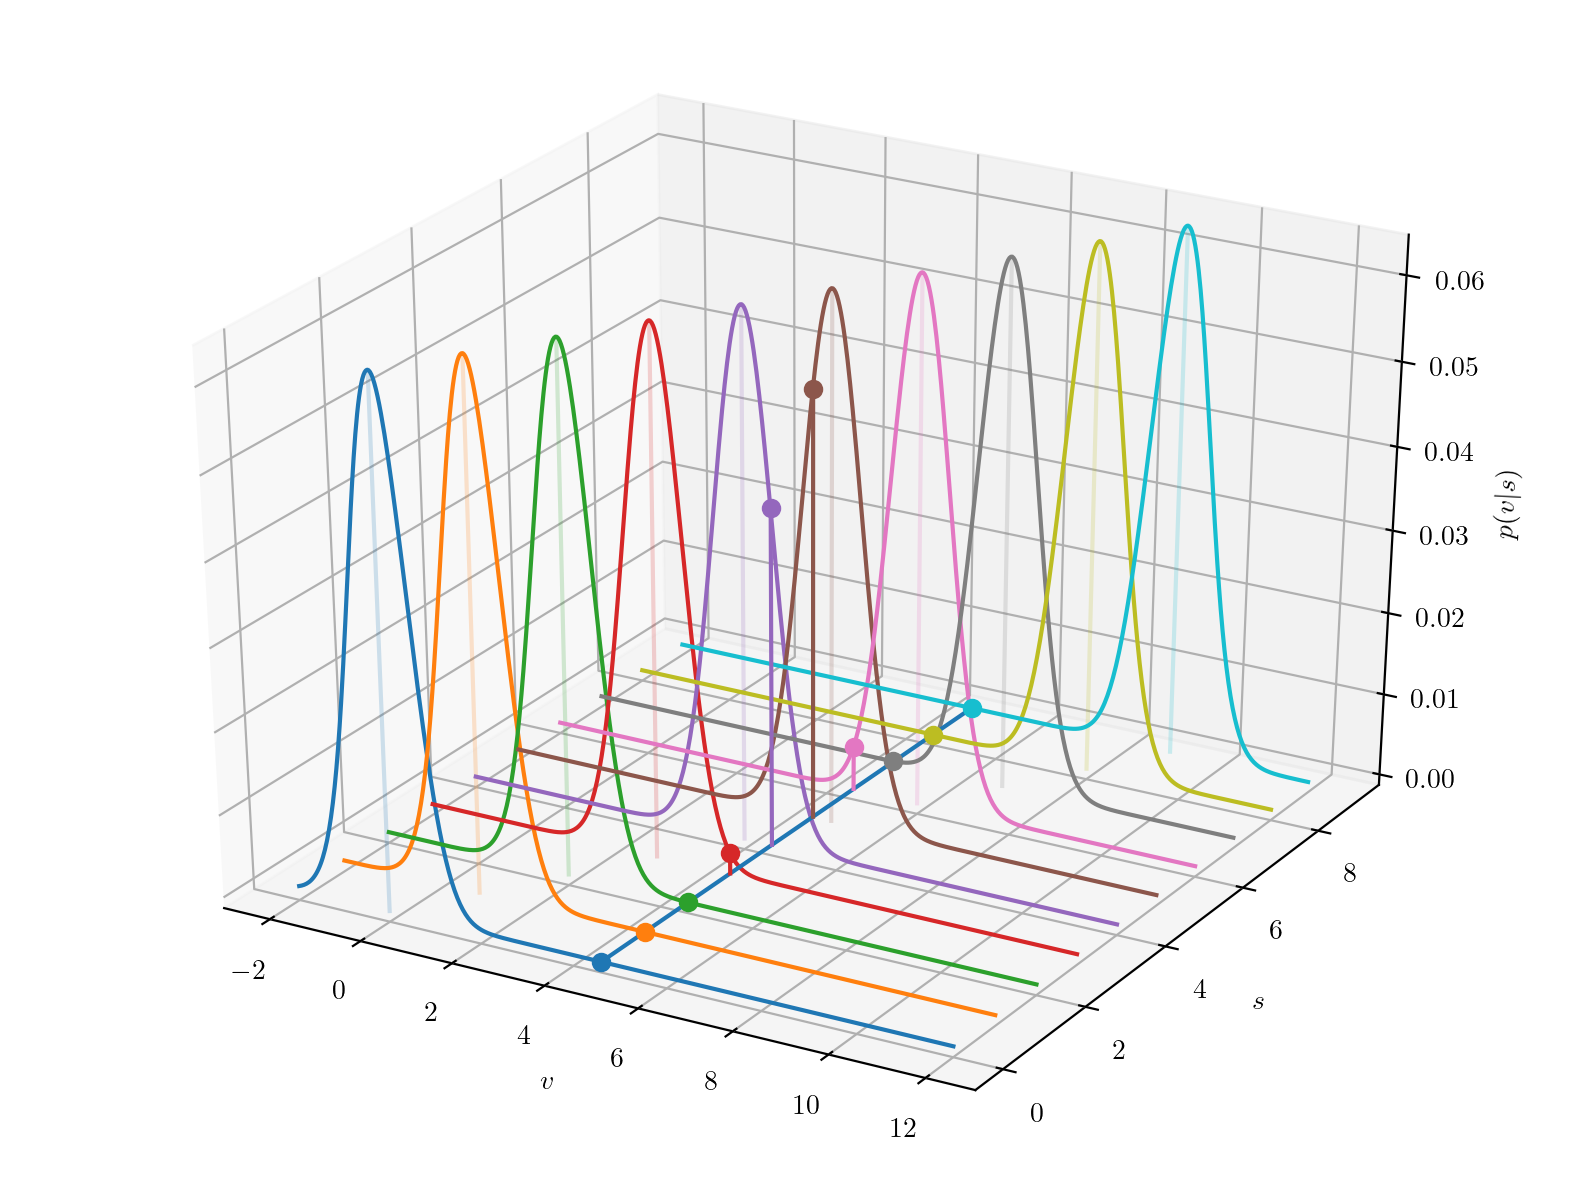

In [10]:
eps_std = 0.63
num = 10

plotv = np.linspace(-2, num+2, 500)
p_v_c_s = np.vstack([scipy.stats.norm.pdf(plotv, loc=l, scale=eps_std) for l in range(num)]).T

obs_v = 4.6

p_vs = p_v_c_s * np.ones(num)[None, :] / num

plt.figure(figsize=(8, 6), dpi=200)
ax = plt.axes(projection ='3d')
for i in range(p_vs.shape[1]):
    ax.plot3D(i * np.ones(3), i * np.ones(3), np.linspace(0, p_vs[:, i].max(), 3),
              color=f'C{i}', alpha=0.2)
    ax.plot3D(plotv, i + np.zeros(len(plotv)), p_vs[:, i])
ax.set_ylabel("$s$")
ax.set_xlabel("$v$")
ax.set_zlabel("$p(v|s)$")

index_v_obs = np.argmin((plotv - obs_v)**2.0)
s_at_v = p_vs[index_v_obs, :]

ax.plot3D(obs_v * np.ones(3), np.linspace(0, p_vs.shape[1] - 1, 3), 0.0 * np.ones(3))
for i in range(p_vs.shape[1]):
    ax.plot3D(obs_v * np.ones(3), i * np.ones(3), np.linspace(0, s_at_v[i], 3), color=f'C{i}')
    ax.plot3D([obs_v], [i], s_at_v[i], 'o', color=f'C{i}')
plt.tight_layout()

Text(0.5, 1.0, 'Posterior distribution')

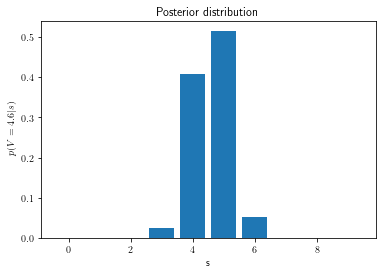

In [11]:
plt.bar(np.arange(len(s_at_v)), s_at_v / s_at_v.sum())
plt.ylabel(f"$p(V={obs_v}|s)$")
plt.xlabel("s")
plt.title("Posterior distribution")

## Continuous Source Voltages
We can also have a continuous source voltage, perhaps if we are sending an analogue signal.
$$S \sim \mathcal U(0, 1)$$
We can again plot the joint and find the posterior by considering a slice along the axis. Do consider different values of obs_v! You will get very different patterns of the posterior.

In [12]:
obs_v = 0.1
eps_std = 0.1

Text(0.5, 1.0, 'Joint distribution $p(v,s)$')

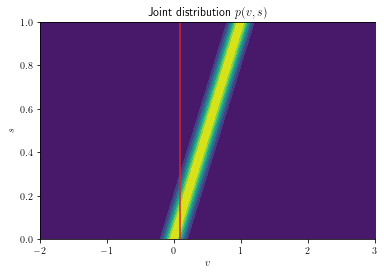

In [13]:
vv = np.linspace(-2, 3, 301)  # Use a different number of points so shape errors can't hide
ss = np.linspace(0, 1, 300)
v, s = np.meshgrid(vv, ss)
p_vs = scipy.stats.norm.pdf(v.ravel(), loc=s.ravel(), scale=eps_std).reshape(len(ss), len(vv))
plt.contourf(v, s, p_vs)
plt.xlabel("$v$")
plt.ylabel("$s$")
plt.axvline(obs_v, color='C3')
plt.title("Joint distribution $p(v,s)$")

In [14]:
dv, ds = vv[1] - vv[0], ss[1] - ss[0]
# Numerical approximation of normalisation: should be close to 1,
# and get closer with more linspace points.
p_vs[:, :].sum() * dv * ds

1.0033444816053476

If we again try to calculate the posterior, we now need to calculate a slightly more difficult integral:
$$
p_V(v) = \int_0^1 p(s, v) \mathrm ds = \int_0^1\mathcal{N}(v; s, \sigma^2) \mathrm ds
$$
Luckily, with a bit of algebra, we can figure this out:
\begin{align}
p_V(v) = \int_0^1 \mathcal{N}(s; v, \sigma^2) \mathrm ds &= \int_{-\infty}^1 \mathcal{N}(s; v, \sigma^2) \mathrm ds - \int_{-\infty}^0 \mathcal{N}(s; v, \sigma^2) \mathrm ds \\
&= \Phi\left(\frac{1-v}{\sigma}\right) - \Phi\left(\frac{-v}{\sigma}\right) \,,
\end{align}
where $\Phi(\cdot)$ is the standard Gaussian cdf.

Text(0.5, 1.0, 'Posterior Density')

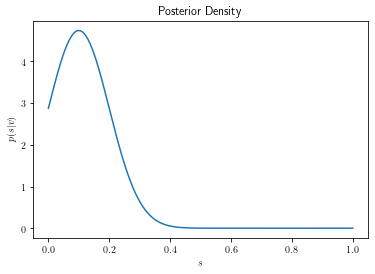

In [15]:
index_v_obs = np.argmin((vv - obs_v)**2.0)
p_s_c_v = p_vs[:, index_v_obs] / (scipy.stats.norm.cdf((-obs_v + 1) / eps_std) - scipy.stats.norm.cdf(-obs_v / eps_std))
plt.plot(ss, p_s_c_v)
plt.xlabel("$s$")
plt.ylabel("$p(s|v)$")
plt.title("Posterior Density")

In [16]:
# We can check if we got the integral correct with a quick numerical integration test, using
# the typical Riemann sum approximation.
p_s_c_v.sum() * ds  # When I ran it, it was close enough, and the gap shrank with a finer grid

1.0047825550135046

## Multivariate Normal
Now let's finally consider a case where the prior on the voltages is Gaussian:
$$S \sim \mathcal{N}(0, 1)\,.$$
We can again calculate the joint at a bunch of places as we did previously, by explicitly multiplying the likelihood and prior:
$$
p(v, s) = p(v|s) p(s) \,.
$$

In [17]:
obs_v = 0.1
eps_std = 0.5

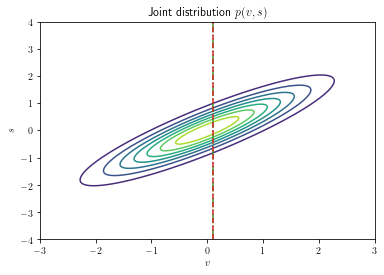

In [18]:
vv = np.linspace(-3, 3, 301)  # Use a different number of points so shape errors can't hide
ss = np.linspace(-4, 4, 300)
v, s = np.meshgrid(vv, ss)
p_vs = (scipy.stats.norm.pdf(v.ravel(), loc=s.ravel(), scale=eps_std)
         * scipy.stats.norm.pdf(s.ravel(), loc=0, scale=1)).reshape(len(ss), len(vv))
plt.contour(v, s, p_vs)
plt.xlabel("$v$")
plt.ylabel("$s$")
plt.axvline(obs_v, color='C2', linestyle='-.')
plt.axvline(0.1, color='C3', linestyle='--')
plt.title("Joint distribution $p(v,s)$")
plt.savefig("./figures-bayesgauss/joint-gauss.png", dpi=200)

We see that this looks like a multivariate Gaussian. That's because it *is* a multivariate Gaussian! And you actually already have the tools to understand why this is. This is because we can write our current variables of interest, as a _linear_ transformation on other Gaussian random variables. In earlier lectures, you showed that this resulted in a multivariate Gaussian distributed random variable.

To be explicit...:
\begin{align}
\begin{bmatrix} s \\ v\end{bmatrix} &= \begin{bmatrix} 1 & 0 \\ 0 & 1\end{bmatrix}\begin{bmatrix} s \\ \epsilon\end{bmatrix} \\
s &\sim \mathcal N(0, 1) \\
\epsilon &\sim \mathcal{N}(0, \sigma^2) \\
\end{align}

To be able to compute the multivariate Gaussian density, we just need to compute the covariance matrix, for which we have the notation:
\begin{align}
\mathbb V_{s,\epsilon}\left[\begin{bmatrix} s \\ v\end{bmatrix}\right] = \Sigma = \begin{bmatrix}\mathbb V[s] & \mathbb{C}[s, v] \\ \mathbb C[v, s] & \mathbb V[s]\end{bmatrix}
\end{align}
We can use expectation identities for this.
\begin{align}
\mathbb V[s] &= 1 \\
\mathbb C[s, v] = \mathbb C[s, v] = \mathbb E_{s,\epsilon}[s(s+\epsilon)] = \mathbb V_s[s] &= 1 && \text{Zero mean} \\
\mathbb V[v] = \mathbb V[s] + \mathbb V[\epsilon] &= 1 + \sigma^2 \\
\Sigma &= \begin{bmatrix}1 & 1 \\ 1 & 1+\sigma^2\end{bmatrix}
\end{align}
By similar expectation identities the mean is zero.

We can confirm that the density we computed above is the same as that which you get by directly computing a multivariate Gaussian pdf.

In [19]:
Σ = np.array([[1, 1], [1, 1+eps_std**2.0]])
x = np.vstack((s.ravel(), v.ravel()))
p_vs2 = np.linalg.det(2*np.pi*Σ) ** -0.5 * np.exp(-0.5*(x * np.linalg.solve(Σ, x)).sum(axis=0)).reshape(len(ss), len(vv))

In [20]:
print(f"Maximum absolute difference: {np.abs(p_vs - p_vs2).max()}")

Maximum absolute difference: 1.6653345369377348e-16


We again find the posterior density, this time for two different observations of $V$. However, in this bit of code, we cheated with finding the normalising constant of the posterior distribution (i.e. $p(v)$). In the next lecture we will show how we can find this in closed-form for a Gaussian distribution.

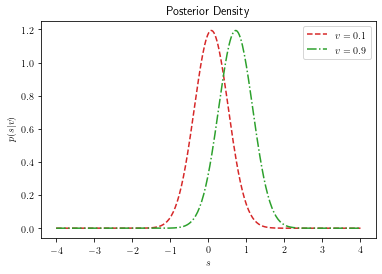

In [21]:
dv, ds = vv[1] - vv[0], ss[1] - ss[0]
for obs_v, style, col in [(0.1, '--', 'C3'), (0.9, '-.', 'C2')]:
    index_v_obs = np.argmin((vv - obs_v)**2.0)
    p_s_c_v = p_vs[:, index_v_obs] / (p_vs[:, index_v_obs].sum() * dv)
    plt.plot(ss, p_s_c_v, linestyle=style, color=col, label=f"$v={obs_v}$")
plt.xlabel("$s$")
plt.ylabel("$p(s|v)$")
plt.title("Posterior Density")
plt.legend()

In [22]:
!jupyter nbconvert --to html l10p2-bayes-voltage.ipynb

[NbConvertApp] Converting notebook l10p2-bayes-voltage.ipynb to html
[NbConvertApp] Writing 2109497 bytes to l10p2-bayes-voltage.html
